In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, RepeatVector
import pandas as pd
import csv
from datetime import datetime

2023-04-19 18:08:31.010015: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 18:08:31.879190: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 18:08:31.888376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 18:08:34.685042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

data.shape

(76, 79, 8736, 11)

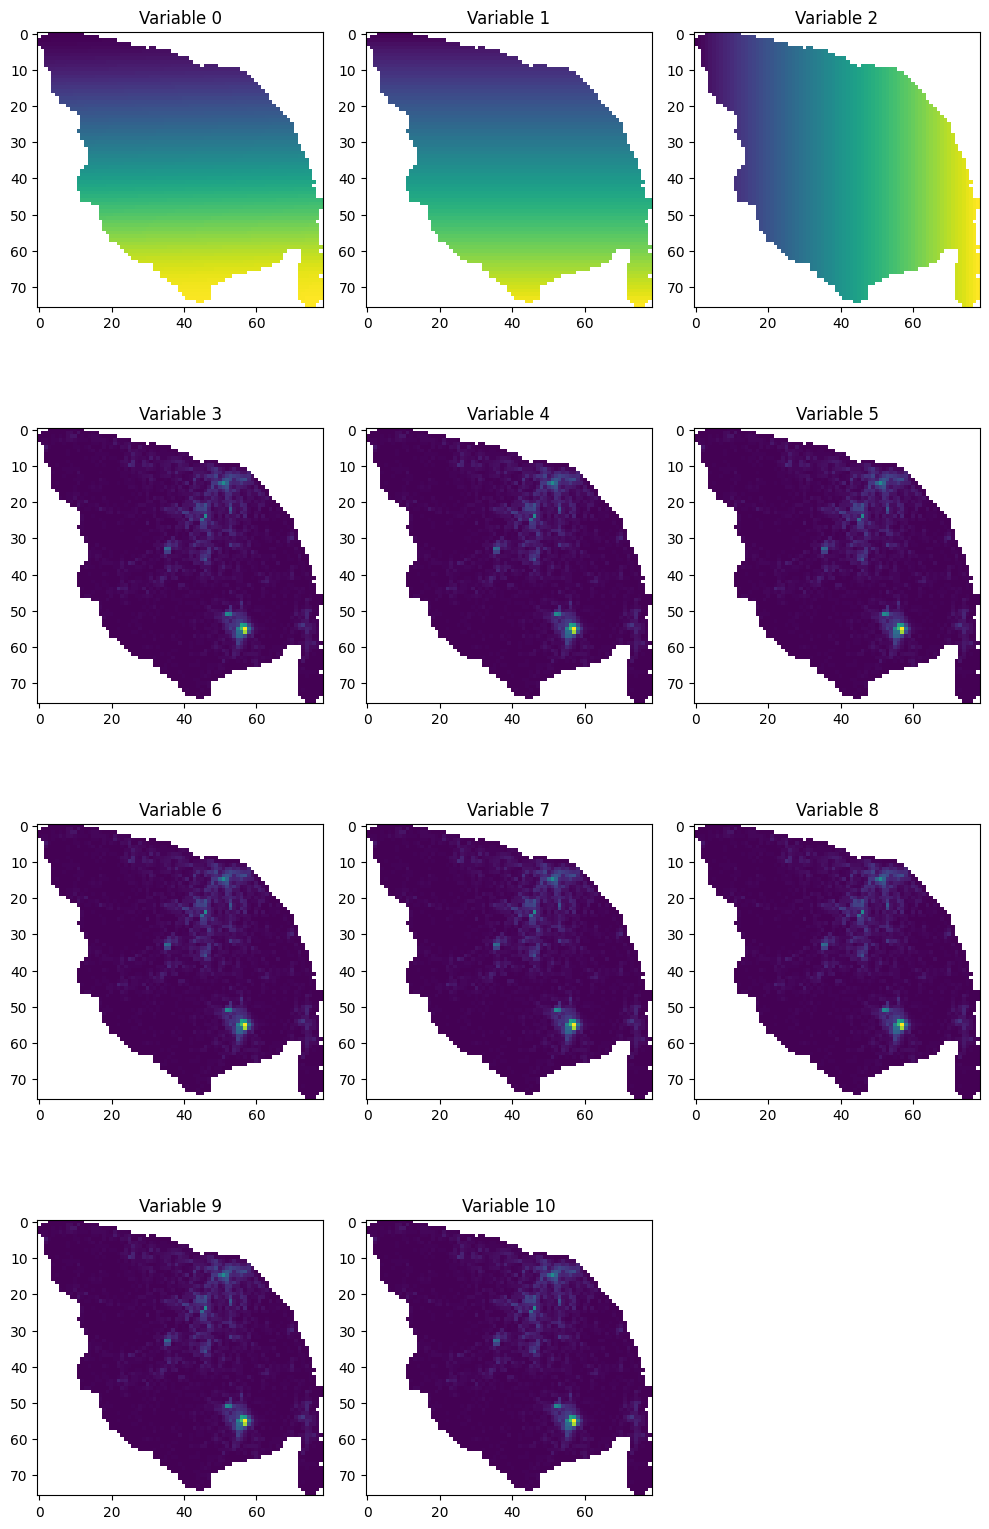

In [3]:
def plot_picture(grid_data, timestamp_index):
    num_vars = grid_data.shape[-1]
    num_rows = int((num_vars + 2) / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 4*num_rows))
    var_list = range(num_vars)
    for var, ax in zip(var_list, axes.flatten()):
        if var < num_vars:
            ax.imshow(grid_data[:,:,timestamp_index,var], interpolation='nearest')
            ax.set_title(f'Variable {var}')
        else:
            ax.axis('off')
    if num_vars % 3 != 0:
        fig.delaxes(axes.flatten()[-1])
    plt.tight_layout()
    plt.show()
    return fig

show_plot = True

if show_plot:
    fig = plot_picture(grid_data = data, timestamp_index = 1000)

Model definition and train

In [4]:
# The depth of this model can be easily increased
# One could add more Conv layer
# Or increase the units on the LSTM to increase the model capability to fit the training data

# For now the model has only 136,167 parameters

def CNN_LSTM(input_shape, output_shape, forecast_range):
    ## Predicting the value of C1 for all the cells for only 1 timeStamp ahead (may be a waste for grid elements of no interest)
    model = tf.keras.Sequential()
    # define CNN model
    model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu', padding='same', input_shape=input_shape)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(2, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(1, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=100))
    model.add(RepeatVector(forecast_range))
    model.add(LSTM(units=100, return_sequences= True))
    model.add(TimeDistributed(Dense(output_shape)))

    model.build(input_shape) # input_shape is the shape of the input data
    model.summary()

    return model

In [5]:
N_IN_24_H = 24*4
FORECAST_RANGE = 4 # 1 hour

In [6]:
def windowed_dataset(data, relevant_cells_mask, window_size, batch_size, shift, forecast_range):
    """
    """

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (window[:-forecast_range], tf.stack([window[-i,:,:,0][relevant_cells_mask] for i in range(forecast_range)])))

    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [7]:
def ingestion(data, window_size, shift, batch_size, forecast_range):
    cell_ids = data[...,0,0]
    relevant_cells_mask = ~np.isnan(cell_ids)
    output_shape = relevant_cells_mask.sum()

    # Setting the timestep dim as the first dimensions
    data = np.transpose(data, (2, 0, 1, 3))
    print(f'Whole dataset shape: {data.shape}')

    # Using only the C's data
    x_data = data[...,3:]
    x_data[np.isnan(x_data)] = 0
    # Train/val split
    x_data_train = x_data[:int(x_data.shape[0]*2/3),...] 
    x_data_val = x_data[int(x_data.shape[0]*2/3):int(x_data.shape[0]*(2/3 + 1/6)),...]
    x_data_test = x_data[int(x_data.shape[0]*(2/3 + 1/6)):,...]

    train_dataset = windowed_dataset(x_data_train, relevant_cells_mask, window_size, batch_size, shift, forecast_range)
    validation_dataset = windowed_dataset(x_data_val, relevant_cells_mask, window_size, batch_size, shift, forecast_range)
    test_dataset = windowed_dataset(x_data_test, relevant_cells_mask, window_size, batch_size, shift, forecast_range)

    return train_dataset, validation_dataset, test_dataset, output_shape

In [74]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that. - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

def train(train_dataset, validation_dataset, input_shape, output_shape, forecast_range, lr, epochs, vis):

    model = CNN_LSTM(input_shape, output_shape, forecast_range)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss)
    # the patience parameter is the number of epochs with no improvement after which training will be stopped.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping, lr_scheduler])

    # summarize history for loss
    if vis:
        # list all data in history
        print(history.history.keys())

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    return model, history.history['loss'], history.history['val_loss']

# Run experiment

In [9]:
def experiment(data, window_size = N_IN_24_H+FORECAST_RANGE, shift = 4, batch_size=32, lr=5e-3, epochs=100, vis=False, model_path='model.h5', forecast_range=4):
    # Ingestion
    train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift, batch_size, forecast_range)
    input_shape = (None,96,76,79,8)

    # Train
    model, train_loss, val_loss = train(train_dataset, validation_dataset, input_shape, output_shape, forecast_range, lr, epochs, vis)
    model.save(model_path)

    ## We don't need this anymore, the fit method will take care of that for us
    # # Model prediction
    # relevant_cells_mask = ~np.isnan(data[...,0,0])
    # ground_truth = x_data_val_and_test[N_IN_24_H,...,0][relevant_cells_mask]
    # pred, mse = predict_evaluate(model, x_data_val_and_test, ground_truth)

    return model, train_loss, val_loss, test_dataset

To run single experiment:
`model, train_loss, val_loss = experiment(data, window_size = N_IN_24_H+FORECAST_RANGE, shift = 4, batch_size=32, lr=1e-2, vis=True, model_path='model.h5')`

## Iterate over multiple window_sizes

In [10]:
header = ['timestamp', 'window', 'forecast_range', 'train_loss', 'val_loss']

In [11]:
# fast

# create a CSV file and open it in write mode
with open(os.path.join(os.path.dirname(os.getcwd()), 'reports', 'iteration_results_fast.csv'), mode='w', newline='') as file:

    writer = csv.writer(file)
    model_fn_list = ['24h_1h', '24h_12h', '48h_1h', '48h_12h', '48_24h', '96h_1h', '96h_12h', '96h_24h']
    # You may be able to increase these if your machine has more that 20 GiB of RAM
    batch_size_list = [32, 32, 16, 16, 16, 8, 8, 8, 8]
    FORECAST_RANGE_list = [4, 12*4, 4, 12*4, 24*4, 4, 12*4, 24*4]

    # The shift parameter is currently set to 1 (shift of 15 min) to use all the available data
    # The number of epochs is 200 but can be increased, but the callback may stop it sooner
    # The lr of 5e-3 might be hight but I think that lr = 1e-3 could make it slow

    # QUESTION: Should we also try with different forecast_ranges ??
    writer.writerow(header)
    for i, window in enumerate([N_IN_24_H, N_IN_24_H, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*4, N_IN_24_H*4, N_IN_24_H*4]):
        _, train_loss, val_loss, _ = experiment(data, window_size = window+FORECAST_RANGE_list[i], shift = 7, batch_size=batch_size_list[i], lr=5e-3, epochs=400, vis=True, model_path = f'models/model{model_fn_list[i]}.h5', forecast_range= FORECAST_RANGE_list[i])
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current timestamp
        row = [timestamp, window, FORECAST_RANGE_list[i], train_loss, val_loss]
        print('FINISH: ', row)
        writer.writerow(row)

Whole dataset shape: (8736, 76, 79, 11)


KeyboardInterrupt: 

In [ ]:
#medium 

# create a CSV file and open it in write mode
with open(os.path.join(os.path.dirname(os.getcwd()), 'reports', 'iteration_results_medium.csv'), mode='w', newline='') as file:

    writer = csv.writer(file)
    model_fn_list = ['24h_1h', '24h_12h', '48h_1h', '48h_12h', '48_24h', '96h_1h', '96h_12h', '96h_24h']
    # You may be able to increase these if your machine has more that 20 GiB of RAM
    batch_size_list = [32, 32, 16, 16, 16, 8, 8, 8, 8]
    FORECAST_RANGE_list = [4, 12*4, 4, 12*4, 24*4, 4, 12*4, 24*4]

    # The shift parameter is currently set to 1 (shift of 15 min) to use all the available data
    # The number of epochs is 200 but can be increased, but the callback may stop it sooner
    # The lr of 5e-3 might be hight but I think that lr = 1e-3 could make it slow

    # QUESTION: Should we also try with different forecast_ranges ??
    writer.writerow(header)
    for i, window in enumerate([N_IN_24_H, N_IN_24_H, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*4, N_IN_24_H*4, N_IN_24_H*4]):
        _, train_loss, val_loss, _ = experiment(data, window_size = window+FORECAST_RANGE_list[i], shift = 3, batch_size=batch_size_list[i], lr=5e-3, epochs=400, vis=True, model_path = f'models/model{model_fn_list[i]}.h5', forecast_range= FORECAST_RANGE_list[i])
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current timestamp
        row = [timestamp, window, FORECAST_RANGE_list[i], train_loss, val_loss]
        print('FINISH: ', row)
        writer.writerow(row)

In [ ]:
#SLOWWW

# create a CSV file and open it in write mode
with open(os.path.join(os.path.dirname(os.getcwd()), 'reports', 'iteration_results_slow.csv'), mode='w', newline='') as file:

    writer = csv.writer(file)
    model_fn_list = ['24h_1h', '24h_12h', '48h_1h', '48h_12h', '48_24h', '96h_1h', '96h_12h', '96h_24h']
    # You may be able to increase these if your machine has more that 20 GiB of RAM
    batch_size_list = [32, 32, 16, 16, 16, 8, 8, 8, 8]
    FORECAST_RANGE_list = [4, 12*4, 4, 12*4, 24*4, 4, 12*4, 24*4]

    # The shift parameter is currently set to 1 (shift of 15 min) to use all the available data
    # The number of epochs is 200 but can be increased, but the callback may stop it sooner
    # The lr of 5e-3 might be hight but I think that lr = 1e-3 could make it slow

    # QUESTION: Should we also try with different forecast_ranges ??
    writer.writerow(header)
    for i, window in enumerate([N_IN_24_H, N_IN_24_H, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*4, N_IN_24_H*4, N_IN_24_H*4]):
        _, train_loss, val_loss, _ = experiment(data, window_size = window+FORECAST_RANGE_list[i], shift = 1, batch_size=batch_size_list[i], lr=5e-3, epochs=400, vis=True, model_path = f'models/model{model_fn_list[i]}.h5', forecast_range= FORECAST_RANGE_list[i])
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current timestamp
        row = [timestamp, window, FORECAST_RANGE_list[i] train_loss, val_loss]
        print('FINISH: ', row)
        writer.writerow(row)

## Using a trained model to perform predictions

Here we can either train a new model, or simply import one already trained.

In [ ]:
# Training a new model
window_size = N_IN_24_H + FORECAST_RANGE
FORECAST_RANGE = 4
shift = 24

model, train_loss, val_loss, test_dataset = experiment(data, window_size = window_size, shift = shift, batch_size=32, lr=5e-3, epochs=3, vis=True, model_path = f'models/model.h5', forecast_range= FORECAST_RANGE)
train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift=shift, batch_size=1, forecast_range=FORECAST_RANGE)

In [ ]:
# Loading a previously trained model
model = tf.keras.models.load_model('models/model.h5')

Next we predict on the whole test dataset. We evaluate the MSE there and save all the predictions

In [57]:
def predict_evaluate(model, x_test, y_test):
    pred = model(x_test).numpy()
    mse = np.mean((y_test - pred)**2)
    return pred, mse

mse_list = []
pred_list = []
y_true_list = []

for x,y in test_dataset:
    pred, mse = predict_evaluate(model, x, y)
    mse_list.append(mse)
    pred_list.append(pred)
    y_true_list.append(y.numpy())
    
predictions = np.stack(pred_list)
ys = np.stack(y_true_list)

MSE = np.mean(mse_list)
print(f'MSE for the test data: {MSE}')

MSE for the test data: 865.0547497045724


Next we plot some predictions and compare it to our ground truth.

In [72]:
# Function to convert the 1D prediction into a 2D image
def pred_into_grid(pred, ground_truth):

    grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")
    dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')

    # grid indexes
    grelha_x = dfs_grid['grelha_x'].values -1
    grelha_y = dfs_grid['grelha_y'].values -1
    grelha_id =  dfs_grid['grelha_id'].values 

    grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
    grelha_id_2d[:] = np.nan
    pred_2d = grelha_id_2d.copy()
    ground_truth_2d = grelha_id_2d.copy()

    # Indices to map from
    idx_2d = np.stack([grelha_y, grelha_x])

    # Assign the elements to the regular rectangular grid
    pred_2d[tuple(idx_2d)] = pred.ravel()
    ground_truth_2d[tuple(idx_2d)] = ground_truth.ravel()

    return pred_2d, ground_truth_2d

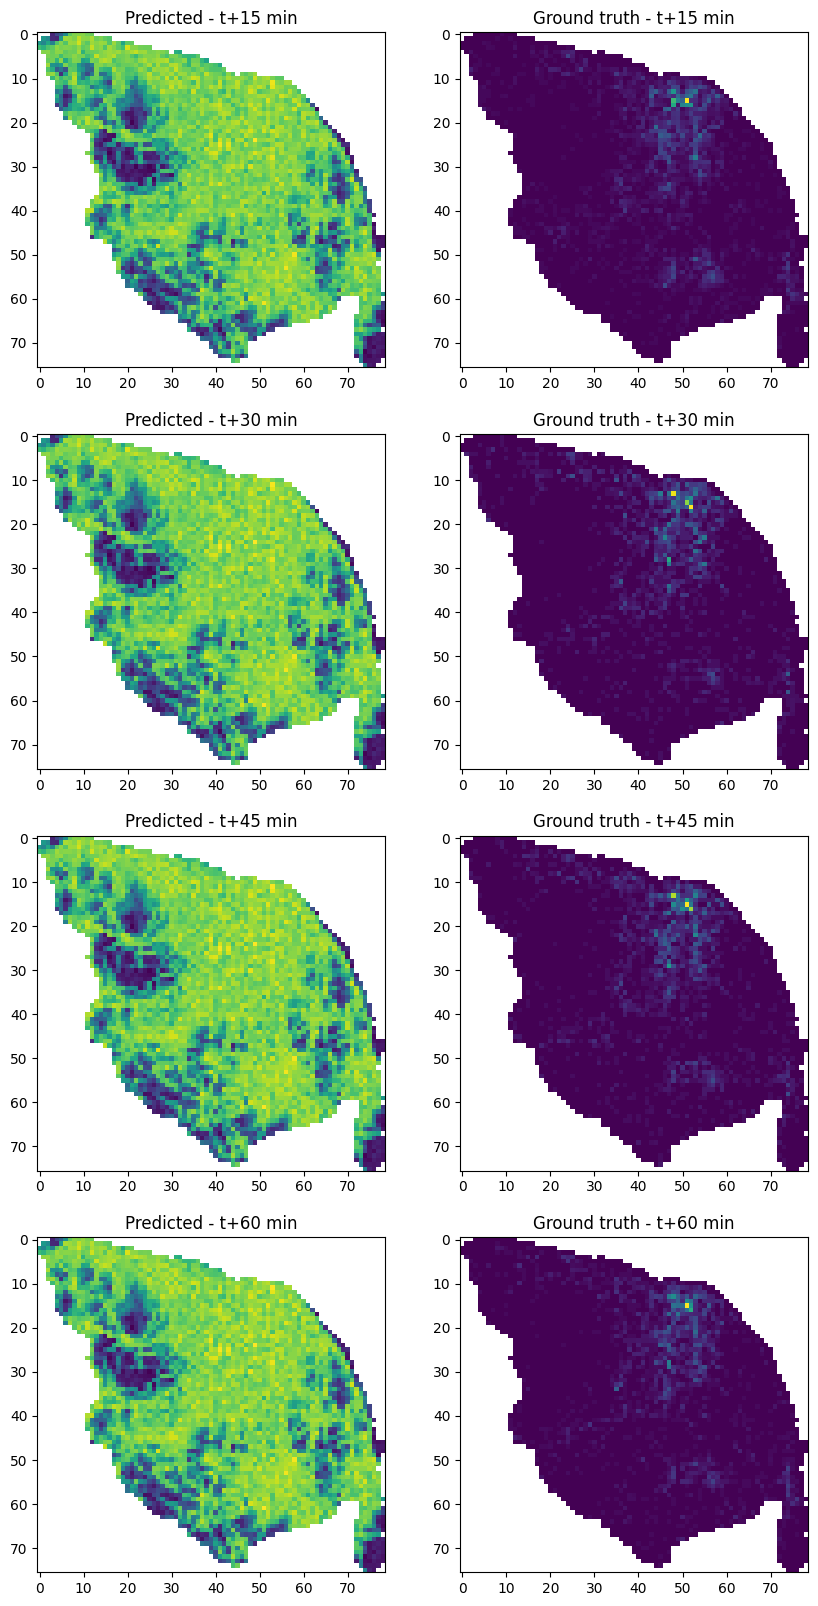

In [73]:
example_pred  = predictions[0,0]
example_truth = ys[0,0]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for time in range(4):
    # Define some pred and ground truth here 
    pred_2d, ground_truth_2d = pred_into_grid(example_pred[time], example_truth[time])

    axs[time,0].set_title(f'Predicted - t+{15*(time+1)} min')
    axs[time,0].imshow(pred_2d)

    axs[time,1].set_title(f'Ground truth - t+{15*(time+1)} min')
    axs[time,1].imshow(ground_truth_2d)

In [ ]:
'''truth_stats = stats.describe(ground_truth.flatten())
pred_stats = stats.describe(pred.flatten())

print("RESULTS")
print("MSE:", mean_squared_error(ground_truth, pred))
print("Ground Truth Stats:", truth_stats)
print("Predictions Stats: ", pred_stats)'''

In [ ]:
'''fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.hist(ground_truth.flatten(), bins=30)
ax1.set_title('Ground Truth')
ax1.axvline(truth_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean - truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean + truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.text(0.05, 0.95, f"Mean: {truth_stats.mean:.2f}\nStd Dev: {truth_stats.variance**0.5:.2f}", transform=ax1.transAxes, fontsize=12, verticalalignment='top')

ax2.hist(pred.flatten(), bins=30)
ax2.set_title('Model Predictions')
ax2.axvline(pred_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean - pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean + pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.text(0.05, 0.95, f"Mean: {pred_stats.mean:.2f}\nStd Dev: {pred_stats.variance**0.5:.2f}", transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.show()'''